# Analysis of COVID-19 Data

### Group 2: Ian Metz, Sanjya Amaratunga, Nermin Kremic, Stephanie Reynolds

### Introduction 
For our analysis of COVID-19, we are going to focus on four countries including the USA, Canada, Italy and India.  These countries are from three different continents and have various income levels and population densities. Canada is a large country, but has a very low population density. Alternatively, India is a medium sized country, with a very large and dense population. We will initially focus on February 21, 2021, the last date of our data set.  We will then use ElasticNet to model our April predictions.

### Data Source
URL: https://github.com/owid/covid-19-data/tree/master/public/data
Data is maintained by Our World in Data and combines multiple data sources including John Hopkins, CDC, ECDC, WHO, and Britain's NHS


### Part 1 - Import libraries required for analysis and create base covid19Dataframe

In [169]:
#### Import required Libraries
import math
import pandas as pd
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import ElasticNet
from pandas.tseries.offsets import DateOffset

#### Import and Scrub Data from Github

In [170]:
# Import CSV
covid19Dataframe = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")

# Filter data to the 4 countries needed (Canada, India, USA, Italy)
covid19Dataframe = covid19Dataframe[covid19Dataframe['iso_code'].isin(["CAN","ITA","IND","USA"])]

# Define needed columns from the dataset for base covid19Dataframe
covid19Columns = ["date","location","total_cases_per_million","new_cases_per_million","total_deaths_per_million","human_development_index","median_age","population"]
covid19Dataframe = covid19Dataframe[covid19Columns]
# Drop rows with empty values in columns. This is typically dates from the start of COVID-19 in 2020
covid19Dataframe.dropna(subset=["new_cases_per_million"],inplace=True)
covid19Dataframe.dropna(subset=["total_deaths_per_million"],inplace=True)

# Convert date column to a date for use in prediction
covid19Dataframe["date"] = pd.to_datetime(covid19Dataframe["date"])
# Reset data frame index
covid19Dataframe.reset_index(drop=True, inplace=True)

In [171]:
# Import CSV and define covid19CountryAnalysis
covid19CountryAnalysis = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")

# Limit dataset to our four targeted countries: Canada, Italy, India and the United States
covid19CountryAnalysis = covid19CountryAnalysis[covid19CountryAnalysis['iso_code'].isin(["CAN","ITA","IND","USA"])]

# Filter dataset to February 21, 2021
covid19CountryAnalysis = covid19CountryAnalysis[covid19CountryAnalysis['date']==('2021-02-21')]

# Reset Index
covid19CountryAnalysis.reset_index(drop=True, inplace=True)

### Part 2 - Begin country analysis with our targeted countries (Canada, India, Italy and United States)

In [172]:
# Display "Total Cases per Million" and "Population Density"
covid19CountryAnalysis[['location','total_cases_per_million','population_density']]

,location,total_cases_per_million,population_density
0,Canada,22540.763,4.037
1,India,7975.228,450.419
2,Italy,46463.134,205.859
3,United States,84996.647,35.608


#### The following pie chart gives a visual representation of the population density across the four countries in our analysis. This view shows the extreme density in India compared to the dispersed population in Canada.

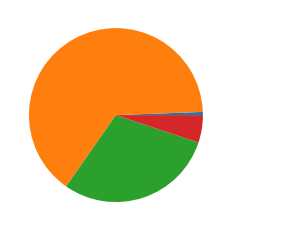

In [173]:
# Using Matplotlib to generate a pie chart visually showing the difference in population density
covid19Countries = covid19CountryAnalysis["location"]
covid19Density = covid19CountryAnalysis["population_density"]
covid19Population = ["population"]
covid19DensityPie = plt.pie(covid19Density, labels=covid19Countries, textprops=dict(color="w"))

#### When looking at new cases for February 21, 2021, the United States outpaces the other three countries, despite having the second lowest population density from our sample.  Our pie chart for New Cases shows Canada with the smallest number of new cases, India and Italy with similar numbers of new cases, and the United States with the largest number of new cases. 

In [174]:
# New cases by country for February 21,2021
covid19NewCasesByLocation = covid19CountryAnalysis[['location',"new_cases"]]
covid19NewCasesByLocation

,location,new_cases
0,Canada,2407.0
1,India,14199.0
2,Italy,13450.0
3,United States,56495.0


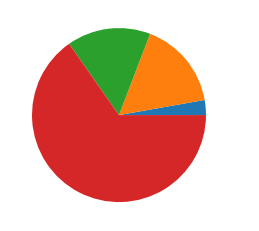

In [175]:
# Display "New Cases" in pie chart
covid19NewCases = covid19CountryAnalysis["new_cases"]
covid19NewCasesPie = plt.pie(covid19NewCases, labels=covid19Countries, textprops=dict(color="w"))

In [176]:
# Display "Total Cases per Million" and "Population Density"
covid19HumanDevelopment = covid19CountryAnalysis[['location','total_cases_per_million','human_development_index']]
covid19HumanDevelopment

,location,total_cases_per_million,human_development_index
0,Canada,22540.763,0.929
1,India,7975.228,0.645
2,Italy,46463.134,0.892
3,United States,84996.647,0.926


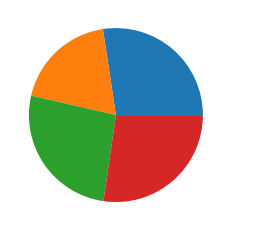

In [177]:
# Using Matplotlib to generate a pie chart visually showing the difference in human_development_index
covid19Countries = covid19CountryAnalysis["location"]
covid19Strictness = covid19CountryAnalysis["human_development_index"]
covid19GDP = ["gdp_per_capita"]
covid19StrictnessPie = plt.pie(covid19Strictness, labels=covid19Countries,textprops=dict(color="w"))

#### When taking poverty and other income related data into account, one could assume that a higher poverty rate will result in a higher number of deaths per million due to lacking infrastructure and medical care. India has the lowest number of hospital beds per thousand, lowest GDP per capita and the highest extreme poverty, yet it also has the lowest number of total deaths per million. The United States has the highest GDP per capita, second lowest rate of extreme poverty, and second highest hospital beds per thousand, yet also has the second highest total deaths per million, only behind Italy.  

In [178]:
# Identify poverty indexes for analysis
covid19NewCasesPoverty = covid19CountryAnalysis[['location',"total_deaths_per_million","hospital_beds_per_thousand","gdp_per_capita","extreme_poverty"]]
covid19NewCasesPoverty

,location,total_deaths_per_million,hospital_beds_per_thousand,gdp_per_capita,extreme_poverty
0,Canada,574.292,2.50,44017.591,0.5
1,India,113.322,0.53,6426.674,21.2
2,Italy,1583.115,3.18,35220.084,2.0
3,United States,1507.230,2.77,54225.446,1.2


#### Based on the analysis of these key statistics, we can infer that the numbers reported by India are under-reported, possibly due to the large population, poverty, and the ability to accurately test, track, and report relevant COVID-19 data.

### Part 3 - Analyze Median Age and Total Cases per Million

#### Pie chart for Median Age and Total Cases per Million

In [179]:
# Import CSV
covid19DataSet = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")

# Make a copy for procesing
covid19Data = covid19DataSet
# Set columns
desiredColumns = ["iso_code","location","date","total_cases_per_million","total_deaths_per_million",
"population_density","median_age","gdp_per_capita"]

# Set date
desiredDate ='2021-02-21'

# Filter data only for the desired Countries:
covid19Data = covid19Data[covid19Data['iso_code'].isin(["CAN","IND","ITA","USA"])]

# Filter data only for the desired Date 
covid19Data = covid19Data[covid19Data['date']==desiredDate]

# Reset index
covid19Data.reset_index(drop=True, inplace=True)

# Get data only for the desired Columns:
covid19Data = covid19Data[desiredColumns]

covid19Data


# Get median_age_prcnt
covid19Data['median_age_prcnt']= (covid19Data['median_age'] / covid19Data['median_age'].sum()) * 100

Pie chart of Median Age 

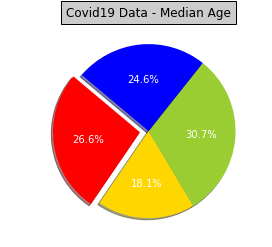

In [180]:
# Define visual effects of pie chart
colors = ['red', 'gold', 'yellowgreen', 'blue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Select fields for analysis to "location" and "median_age"
covid19DataLocations = covid19Data["location"]
covid19DataMedianAge = covid19Data["median_age"]
plt.pie(covid19DataMedianAge, explode=explode, labels=covid19DataLocations, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140, textprops=dict(color="w"))

# Set pie chart title
plt.title("Covid19 Data - Median Age", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

Pie chart of Total Cases per Million

In [181]:
# Get total_cases_prcnt
covid19DataTotalCasesPrcnt = (covid19Data['total_cases_per_million'] / covid19Data['total_cases_per_million'].sum()) * 100
covid19Data['total_cases_prcnt']=covid19DataTotalCasesPrcnt
covid19Data

,iso_code,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,gdp_per_capita,median_age_prcnt,total_cases_prcnt
0,CAN,Canada,2021-02-21,22540.763,574.292,4.037,41.4,44017.591,26.572529,13.916132
1,IND,India,2021-02-21,7975.228,113.322,450.419,28.2,6426.674,18.100128,4.923717
2,ITA,Italy,2021-02-21,46463.134,1583.115,205.859,47.9,35220.084,30.744544,28.685237
3,USA,United States,2021-02-21,84996.647,1507.230,35.608,38.3,54225.446,24.582798,52.474914


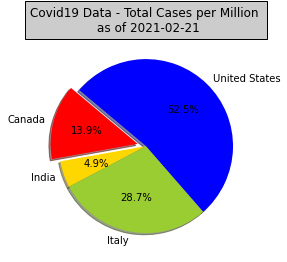

In [182]:
# Define visual effects of pie chart
colors = ['red', 'gold', 'yellowgreen', 'blue']
explode = (0.1, 0, 0, 0)  # explode 1st slice


# Select fields for analysis to "location" and "total_cases_per_million"
covid19DataLocations = covid19Data["location"]
covid19DataTotalCases = covid19Data["total_cases_per_million"]
plt.pie(covid19DataTotalCases, explode=explode, labels=covid19DataLocations, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140, textprops=dict(color="w"))

# Set pie chart title
plt.title("Covid19 Data - Total Cases per Million \n as of 2021-02-21", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

Observations: Italy has the highest Median Age. But USA has the highest Total Cases per Million. So no direct coorelation. The data for India does have a very postive coorelation. 

### Plot chart of Median Age and Total Cases per Million ("Total Cases") 

In [183]:
# Sort by median_age to have an ascending order
covid19Data= covid19Data.sort_values('median_age',ascending=True)
covid19Data

,iso_code,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,gdp_per_capita,median_age_prcnt,total_cases_prcnt
1,IND,India,2021-02-21,7975.228,113.322,450.419,28.2,6426.674,18.100128,4.923717
3,USA,United States,2021-02-21,84996.647,1507.230,35.608,38.3,54225.446,24.582798,52.474914
0,CAN,Canada,2021-02-21,22540.763,574.292,4.037,41.4,44017.591,26.572529,13.916132
2,ITA,Italy,2021-02-21,46463.134,1583.115,205.859,47.9,35220.084,30.744544,28.685237


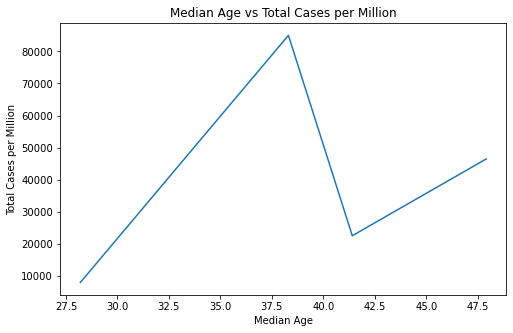

In [184]:
# Define chart size and labels
plt.figure(num = 2, figsize=(8, 5))
plt.xlabel("Median Age")
plt.ylabel("Total Cases per Million")
plt.title("Median Age vs Total Cases per Million")

# Select fields for analysis
medianAge = covid19Data["median_age"]
totalCasesPerMillion = covid19Data["total_cases_per_million"]
plt.plot(medianAge, totalCasesPerMillion)
plt.show()

Observations: I was expecting to see a continious increase in Total Cases per Million with the increase in Median Age. But the Total Cases per Million increased with the Median Age (initially) and then decreased, before increasing again. It could be due to the fact that the sample included only 4 countries.  

### Linear regression line plot chart of Median Age and Total Cases per Million ("Total Cases") using more countries 

In [185]:
# Make a copy for procesing
covid19Data = covid19DataSet

# Select columns
desiredColumns = ["iso_code","location","date","total_cases_per_million","total_deaths_per_million","population_density","median_age","gdp_per_capita"]

# Filter data only for the desired Date 
covid19Data = covid19Data[covid19Data['date']==('2021-02-21')]

# Reset index
covid19Data.reset_index(drop=True, inplace=True)

# Get data only for the desired Columns:
covid19Data = covid19Data[desiredColumns]

covid19Data

,iso_code,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,gdp_per_capita
0,AFG,Afghanistan,2021-02-21,1428.368,62.474,54.422,18.6,1803.987
1,OWID_AFR,Africa,2021-02-21,2856.488,75.590,NaN,NaN,NaN
2,ALB,Albania,2021-02-21,34834.248,578.914,104.871,38.0,11803.431
3,DZA,Algeria,2021-02-21,2552.208,67.524,17.348,29.1,13913.839
4,AND,Andorra,2021-02-21,138471.494,1384.844,163.755,NaN,NaN
...,...,...,...,...,...,...,...,...
196,VNM,Vietnam,2021-02-21,24.482,0.360,308.127,32.6,6171.884
197,OWID_WRL,World,2021-02-21,14295.827,316.511,58.045,30.9,15469.207
198,YEM,Yemen,2021-02-21,72.588,20.754,53.508,20.3,1479.147
199,ZMB,Zambia,2021-02-21,4052.610,55.483,22.995,17.7,3689.251


In [186]:
# Drop only if NaN in specific columns
covid19Data.dropna(subset=["median_age"],inplace=True) 
covid19Data.dropna(subset=["total_cases_per_million"],inplace=True)

In [187]:
# Sort for the graphing 
covid19Data= covid19Data.sort_values('median_age',ascending=True)

In [188]:
# Create COVID-19 regression
covid19Line = np.polyfit(covid19Data['median_age'],covid19Data['total_cases_per_million'],1)
covid19SetLine = np.poly1d(covid19Line)

<AxesSubplot:xlabel='median_age'>

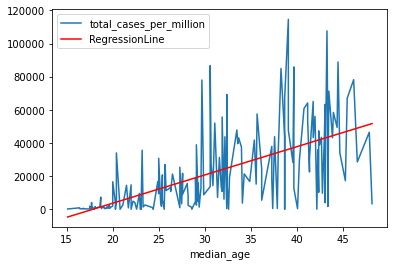

In [189]:
# Define COVID-19 regression plot
covid19Data.insert(6,'RegressionLine',covid19SetLine(covid19Data['median_age']))
ax = covid19Data.plot(x = 'median_age',y='total_cases_per_million')
covid19Data.plot(x='median_age', y='RegressionLine',color='Red',ax=ax)

Observations: As expected, the graph clealy shows an upward trend of  Total Cases per Million  with the increase in Median Age.

#### Conclusion: We may infer that Median Age is a significant factor that affects the case count in a country